In [2]:
import  os
import  pandas as pd
from    tqdm import tqdm
import  numpy as np
from    multiprocessing import get_context as context
from    matplotlib import pyplot as plt
%matplotlib inline

# Read the files

# Parameters


header      = ['EventID','TrackID','Particle','EnergyDeposited','XPosition','YPosition','ZPosition','LocalTime','Volume', 'Initial Energy', 'Origin Volume', 'MigrantID']
PROCESSES   = os.cpu_count()-1
Pool        = context("fork").Pool

# Find the files
foldername  = f'../build1TooMany/output'
os.system(f'rm -rf ../build1TooMany/output/.ipynb_checkpoints')
filenames   = os.listdir(foldername)

print(f'Found {len(filenames)} data files in {foldername}')

def parallel(function):
    def inner(input_array):
        # Parallelize excecution them
        with Pool(PROCESSES) as pool:
            output = list(tqdm(pool.imap(function, input_array),total=len(input_array)))
        return output 
    return inner

# Function to load a single file
def loadfile(filename):
    df = pd.read_csv(os.path.join(foldername,filename),skiprows=16,names=header)
    df.insert(0, 'Filename', filename)
    return df

Found 4096 data files in ../build1TooMany/output


# Cosmic Run

## Heat propagation check

In [5]:
mm = 1
cm = 10
micron = 10**(-3)
nm = 10**(-6)

cryostatBottom = -698.771 * mm


copperThickness = 3 * mm
separation      = 2 * mm
copperBoxX      = 2.5 * cm
copperBoxY      = 2.5 * cm
copperBoxPosX   = 0 * cm
copperBoxPosY   = cryostatBottom + copperBoxY/2 + 11.5 * cm + copperThickness
copperBoxPosZ   = 0 * cm

stackX    = 0.5*mm + 150*2*nm + 500*2*nm
stackPosX = copperBoxPosX - copperBoxX/2 + copperThickness + separation + stackX/2
stackPosY = copperBoxPosY
stackPosZ = copperBoxPosZ

tesPosX   = stackX / 2 + 1 * micron / 2
tesPosY   = 0
tesPosZ   = 0

tesVolume = 20*20*1*micron**3

substratePosition = np.array([stackPosX, stackPosY, stackPosZ])
tesPosition       = np.array([tesPosX, tesPosY, tesPosZ])
tesPosition       = tesPosition + substratePosition
tesArea = 20 * 20 * micron**2

## Check file by file

In [3]:
def processFile(filename):
    """Filtering out tes hits according to"""

#     # loading tes separately because of some error when using a copy
#     # using A cos(a) / (4*pi*r^2) approach to calculate the energy that reaches tes 
    
    tes = loadfile(filename)
    tes = tes[tes.Volume.str.contains('E')] # select only substrate volumes 
    
#     # tes['Distance'] = np.sqrt((tes.XPosition - tesPosition[0])**2 + (tes.YPosition - tesPosition[1])**2 + (tes.ZPosition - tesPosition[2])**2) # distance from a edep to tes
#     # tes['EnergyReached'] = tes.EnergyDeposited * tesArea * abs(tes.YPosition - tesPosition[1]) / (4 * np.pi * tes.Distance**3) # energy reached duh
#     # tes = tes.groupby('EventID')['EnergyReached'].sum().reset_index() # summing it per event
    tes = tes.groupby('EventID')['EnergyDeposited'].sum().reset_index()
    # tes = tes[tes.EnergyReached > 1*10**(-6)] # filtering out according to tes threshold
    tes = tes[tes.EnergyDeposited > 0.0]

    # loading the rest of the dataframe
    data = loadfile(filename)
    # data = data[data['Particle'] == 'e-']
    data['hit'] = (data.EventID.isin(tes.EventID)).astype(int) # we assign event row a hit of 1 if it was registered by the tes above 
    # data = data[(data.Particle != 'e-') | (data['Origin Volume'].str.contains('phys'))]

    # filter electrons jumping from one saber to another
    # mask = ~(data['Origin Volume'].str.contains('phys') & (data.Volume != data['Origin Volume']))
    # data = data[mask]
    


    # data = data.groupby(['Filename','EventID', 'Volume', 'hit'])['EnergyDeposited'].sum().reset_index() # sum the energy per volume, hit and eventid are overlapping perfectly
    data = data.groupby(['Filename','EventID', 'Volume','hit'])['EnergyDeposited'].sum().reset_index() # sum the energy per volume, hit and eventid are overlapping perfectly

    
    data = data[~(data.Volume.str.contains('Silicon'))] # removing substrate volumes


    #saber thresholds
    
    t1 = 0.222
    t2 = 0.251
    t3 = 0.251

    t = 0.260

    mask = (data['Volume'] != 'phys1') | (data['EnergyDeposited'] >= t)
    data = data[mask]

    mask = (data['Volume'] != 'phys2') | (data['EnergyDeposited'] >= t)
    data = data[mask]

    mask = (data['Volume'] != 'phys3') | (data['EnergyDeposited'] >= t)
    data = data[mask]

    data = data.groupby(['Filename','EventID', 'hit'])['Volume'].count().reset_index() # count how many sabers were hit during the event
    data['Triple'] = (data.Volume == 3).astype(int) # triple coincidences
    data['Quadruple'] = ((data.hit == 1) & (data.Volume == 3)).astype(int) # quadruple 

    tesHits = len(tes)
    triple = sum(data.Triple)
    quad = sum(data.Quadruple)

    return (tesHits, triple, quad)


processFiles        = parallel(processFile)
processed           = processFiles(filenames)
processed           = np.array(processed).T

tesHits             = sum(processed[0])
tripleEvents        = sum(processed[1])
quadrupleEvents     = sum(processed[2])

content = f"TES Hits = {tesHits}; Triple Coincidences = {tripleEvents}; Quadruple Coincidences = {quadrupleEvents}"
print(content)

100%|██████████| 4096/4096 [02:00<00:00, 33.88it/s]

TES Hits = 9128; Triple Coincidences = 107524; Quadruple Coincidences = 46


In [ ]:
 for particle in ['mu+', 'gamma', 'mu-', 'e-', 'e+', 'neutron', 'C12', 'proton',
       'nu_e', 'anti_nu_e', 'anti_nu_mu', 'pi-', 'C13', 'nu_mu', 'pi+',
       'anti_proton']:
        
    def processFile(filename):
        """Filtering out tes hits according to"""

        # loading tes separately because of some error when using a copy
        # using A cos(a) / (4*pi*r^2) approach to calculate the energy that reaches tes 
        tes = loadfile(filename)
        tes = tes[tes.Volume.str.contains('E')] # select only substrate volumes 
        # tes['Distance'] = np.sqrt((tes.XPosition - tesPosition[0])**2 + (tes.YPosition - tesPosition[1])**2 + (tes.ZPosition - tesPosition[2])**2) # distance from a edep to tes
        # tes['EnergyReached'] = tes.EnergyDeposited * tesArea * abs(tes.YPosition - tesPosition[1]) / (4 * np.pi * tes.Distance**3) # energy reached duh
        # tes = tes.groupby('EventID')['EnergyReached'].sum().reset_index() # summing it per event
        tes = tes.groupby('EventID')['EnergyDeposited'].sum().reset_index()
        # tes = tes[tes.EnergyReached > 1*10**(-6)] # filtering out according to tes threshold
        tes = tes[tes.EnergyDeposited > 0.0]

        # loading the rest of the dataframe
        data = loadfile(filename)
        data = data[data['Particle'] == particle]
        data['hit'] = (data.EventID.isin(tes.EventID)).astype(int) # we assign event row a hit of 1 if it was registered by the tes above 

        # filter electrons jumping from one saber to another
        mask = ~(data['Origin Volume'].str.contains('phys') & (data.Volume != data['Origin Volume']))
        data = data[mask]


        data = data.groupby(['Filename','EventID', 'Volume', 'hit'])['EnergyDeposited'].sum().reset_index() # sum the energy per volume, hit and eventid are overlapping perfectly
        data = data[~(data.Volume.str.contains('Silicon'))] # removing substrate volumes


        #saber thresholds

        t1 = 0.222
        t2 = 0.251
        t3 = 0.251

        t = 0.200

        mask = (data['Volume'] != 'phys1') | (data['EnergyDeposited'] >= t1)
        data = data[mask]

        mask = (data['Volume'] != 'phys2') | (data['EnergyDeposited'] >= t2)
        data = data[mask]

        mask = (data['Volume'] != 'phys3') | (data['EnergyDeposited'] >= t3)
        data = data[mask]

        data = data.groupby(['Filename','EventID', 'hit'])['Volume'].count().reset_index() # count how many sabers were hit during the event
        data['Triple'] = (data.Volume == 3).astype(int) # triple coincidences
        data['Quadruple'] = ((data.hit == 1) & (data.Volume == 3)).astype(int) # quadruple 

        tesHits = len(tes)
        triple = sum(data.Triple)
        quad = sum(data.Quadruple)

        return (tesHits, triple, quad)


    processFiles        = parallel(processFile)
    processed           = processFiles(filenames)
    processed           = np.array(processed).T

    tesHits             = sum(processed[0])
    tripleEvents        = sum(processed[1])
    quadrupleEvents     = sum(processed[2])

    content = f"TES Hits = {tesHits}; Triple Coincidences = {tripleEvents}; Quadruple Coincidences = {quadrupleEvents}"
    print(content)

In [3]:
data = loadfile(filenames[1])

In [6]:
max(data.LocalTime)

248638.0

## Processing for Isaac

In [13]:
def processFile(filename):
    """Filtering out tes hits according to"""

    # loading tes separately because of some error when using a copy
    # using A cos(a) / (4*pi*r^2) approach to calculate the energy that reaches tes 
    tes = loadfile(filename)
    tes = tes[tes.Volume.str.contains('E')] # select only substrate volumes 
    # tes['Distance'] = np.sqrt((tes.XPosition - tesPosition[0])**2 + (tes.YPosition - tesPosition[1])**2 + (tes.ZPosition - tesPosition[2])**2) # distance from a edep to tes
    # tes['EnergyReached'] = tes.EnergyDeposited * tesArea * abs(tes.YPosition - tesPosition[1]) / (4 * np.pi * tes.Distance**3) # energy reached duh
    # tes = tes.groupby('EventID')['EnergyReached'].sum().reset_index() # summing it per event
    tes = tes.groupby('EventID')['EnergyDeposited'].sum().reset_index()
    # tes = tes[tes.EnergyReached > 1*10**(-6)] # filtering out according to tes threshold
    tes = tes[tes.EnergyDeposited > 0.0]
    
    # loading the rest of the dataframe
    data = loadfile(filename)
    data['hit'] = (data.EventID.isin(tes.EventID)).astype(int) # we assign event row a hit of 1 if it was registered by the tes above 
    
    # filter electrons jumping from one saber to another
    mask = ~(data['Origin Volume'].str.contains('phys') & (data.Volume != data['Origin Volume']))
    data = data[mask]
    
    
    data = data.groupby(['Filename','EventID', 'Volume', 'hit'])['EnergyDeposited'].sum().reset_index() # sum the energy per volume, hit and eventid are overlapping perfectly
    data = data[~(data.Volume.str.contains('Silicon'))] # removing substrate volumes
    

    #saber thresholds
    
    mask = (data['Volume'] != 'phys1') | (data['EnergyDeposited'] >= 0.198)
    data = data[mask]
    
    mask = (data['Volume'] != 'phys2') | (data['EnergyDeposited'] >= 0.183)
    data = data[mask]
    
    mask = (data['Volume'] != 'phys3') | (data['EnergyDeposited'] >= 0.229)
    data = data[mask]
    
    data = data.groupby(['Filename','EventID', 'hit'])['Volume'].count().reset_index() # count how many sabers were hit during the event
    data['Triple'] = (data.Volume == 3).astype(int) # triple coincidences
    data['Quadruple'] = ((data.hit == 1) & (data.Volume == 3)).astype(int) # quadruple 

    # tesHits = len(tes)
    # triple = sum(data.Triple)
    # quad = sum(data.Quadruple)

    # return (tesHits, triple, quad)
    # return triple
    
    return data

processFiles        = parallel(processFile)
processed           = processFiles(filenames)
# processed           = np.array(processed).T

# tesHits             = sum(processed[0])
# tripleEvents        = sum(processed[1])
# quadrupleEvents     = sum(processed[2])

# content = f"TES Hits = {tesHits}; Triple Coincidences = {tripleEvents}; Quadruple Coincidences = {quadrupleEvents}"
# print(content)


data = pd.concat(processed)
data

100%|██████████| 4096/4096 [02:29<00:00, 27.43it/s]


,Filename,EventID,hit,Volume,Triple,Quadruple
0,TES-run0-rank1158_nt_hits.csv,82,0,1,0,0
1,TES-run0-rank1158_nt_hits.csv,135,0,1,0,0
2,TES-run0-rank1158_nt_hits.csv,146,0,1,0,0
3,TES-run0-rank1158_nt_hits.csv,201,0,1,0,0
4,TES-run0-rank1158_nt_hits.csv,238,0,1,0,0
...,...,...,...,...,...,...
7109,TES-run0-rank1486_nt_hits.csv,488143,0,1,0,0
7110,TES-run0-rank1486_nt_hits.csv,488181,0,1,0,0
7111,TES-run0-rank1486_nt_hits.csv,488183,0,1,0,0
7112,TES-run0-rank1486_nt_hits.csv,488212,0,1,0,0


In [14]:
data.to_csv('../isaac.csv')

## triple coincidence deviation calculation

In [6]:
def processFile(filename):


    tes = loadfile(filename)
    tes = tes[tes.Volume.str.contains('E')] 
    tes = tes.groupby('EventID')['EnergyDeposited'].sum().reset_index()
    tes = tes[tes.EnergyDeposited > 0.0]
    
    data = loadfile(filename)
    data['hit'] = (data.EventID.isin(tes.EventID)).astype(int) # we assign event row a hit of 1 if it was registered by the tes above 
    
    # filter electrons jumping from one saber to another
    mask = ~(data['Origin Volume'].str.contains('phys') & (data.Volume != data['Origin Volume']))
    data = data[mask]
    
    
    data = data.groupby(['EventID', 'Volume', 'hit'])['EnergyDeposited'].sum().reset_index() # sum the energy per volume, hit and eventid are overlapping perfectly
    data = data[~(data.Volume.str.contains('Silicon'))] # removing substrate volumes
        
    triples = []
    thresholds = np.arange(0.1,1.1,0.1)
    
    for threshold in thresholds:
        
        dataCopy = data[data.EnergyDeposited >= threshold]
        dataCopy = dataCopy.groupby(['EventID', 'hit'])['Volume'].count().reset_index() # count how many sabers were hit during the event
        dataCopy['Triple'] = (dataCopy.Volume == 3).astype(int) # triple coincidences

        triple = sum(dataCopy.Triple)
        triples.append(triple)
        
    return np.array(triples)

In [7]:
processed = parallel(processFile)(filenames)

100%|██████████| 4096/4096 [02:26<00:00, 27.90it/s]


In [8]:
processed = np.array(processed).T

In [10]:
triples = [sum(array) for array in processed]

In [12]:
triples

[62225, 54210, 48669, 43950, 39992, 36360, 32926, 29878, 27288, 24771]

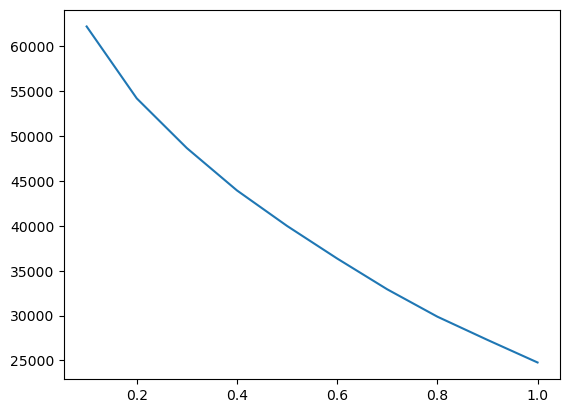

In [11]:
plt.plot(np.arange(0.1,1.1,0.1), triples)

## tes double coincidences 

In [3]:
def processFile(filename):
    file = loadfile(filename)
    file['ID'] = file.Filename + file.EventID.astype(str)
    file = file.drop(columns = ['Filename', 'EventID'])

    tesE = file[file.Volume.str.contains('E')]
    tesE = tesE.groupby(['ID'])['EnergyDeposited'].sum().reset_index()
    tesE = tesE[tesE.EnergyDeposited > 0.0]

    tesB = file[file.Volume.str.contains('B')]
    tesB = tesB.groupby(['ID'])['EnergyDeposited'].sum().reset_index()
    tesB = tesB[tesB.EnergyDeposited > 0.0]

    TESdoubleCoincidence = pd.merge(tesB, tesE, on = ['ID'], how = 'inner')
    return len(TESdoubleCoincidence)

processFiles        = parallel(processFile)
processed           = processFiles(filenames)

doubleCoincidences  = sum(processed)
print("TES double coincidences = ", doubleCoincidences)

100%|██████████| 4096/4096 [01:28<00:00, 46.35it/s]


TES double coincidences =  161


## All files at once if trigger on TES's was on

In [10]:
files = pd.concat(parallel(loadfile)(filenames))
files

100%|██████████| 1839/1839 [00:07<00:00, 252.81it/s]


,Filename,EventID,TrackID,Particle,EnergyDeposited,XPosition,YPosition,ZPosition,LocalTime,Volume,Initial Energy,Origin Volume,MigrantID
0,TES-run0-rank1666_nt_hits.csv,268,139,gamma,0.000000,-88.77450,-778.817,7.11037,0.976468,phys1,510.999,logicMagneticShield_PV,-1
1,TES-run0-rank1666_nt_hits.csv,467,1,gamma,0.000000,-61.83350,-778.817,47.77360,4.636240,phys2,14228.800,worldVolume_PV,-1
2,TES-run0-rank1666_nt_hits.csv,705,1,mu-,1.485280,-88.82970,-764.408,28.28530,7.634300,phys2,1026080.000,worldVolume_PV,-1
3,TES-run0-rank1666_nt_hits.csv,705,1,mu-,1.798350,-95.73560,-771.374,22.00000,7.673330,phys2,1026080.000,worldVolume_PV,-1
4,TES-run0-rank1666_nt_hits.csv,705,1,mu-,1.325880,-103.11300,-778.817,15.27370,7.715060,phys1,1026080.000,worldVolume_PV,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16168,TES-run0-rank1007_nt_hits.csv,246934,3,e+,0.003517,-34.62090,-759.995,-24.86310,0.358197,phys3,10395.300,Cryostat_Aluminum_PV,-1
16169,TES-run0-rank1007_nt_hits.csv,246934,3,e+,0.000000,-34.62090,-759.995,-24.86310,0.358197,phys3,10395.300,Cryostat_Aluminum_PV,-1
16170,TES-run0-rank1007_nt_hits.csv,246934,15,gamma,0.000000,-30.10430,-762.277,-22.00000,0.019393,phys3,510.999,phys3,-1
16171,TES-run0-rank1007_nt_hits.csv,246934,15,gamma,0.000000,2.64591,-778.817,-1.23980,0.160011,phys1,510.999,phys3,-1


In [20]:
muon = files
muon = muon[muon.Particle.str.contains('mu-')]
data = files
data['muon'] = (data.EventID.isin(muon.EventID)).astype(int)
data = data[data['muon'] == 1]
data

,Filename,EventID,TrackID,Particle,EnergyDeposited,XPosition,YPosition,ZPosition,LocalTime,Volume,Initial Energy,Origin Volume,MigrantID,muon
0,TES-run0-rank1666_nt_hits.csv,268,139,gamma,0.000000,-88.77450,-778.817,7.11037,0.976468,phys1,510.999,logicMagneticShield_PV,-1,1
2,TES-run0-rank1666_nt_hits.csv,705,1,mu-,1.485280,-88.82970,-764.408,28.28530,7.634300,phys2,1026080.000,worldVolume_PV,-1,1
3,TES-run0-rank1666_nt_hits.csv,705,1,mu-,1.798350,-95.73560,-771.374,22.00000,7.673330,phys2,1026080.000,worldVolume_PV,-1,1
4,TES-run0-rank1666_nt_hits.csv,705,1,mu-,1.325880,-103.11300,-778.817,15.27370,7.715060,phys1,1026080.000,worldVolume_PV,-1,1
5,TES-run0-rank1666_nt_hits.csv,705,6,e-,0.017295,-88.77020,-764.463,28.22370,0.000407,phys2,426.225,phys2,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16168,TES-run0-rank1007_nt_hits.csv,246934,3,e+,0.003517,-34.62090,-759.995,-24.86310,0.358197,phys3,10395.300,Cryostat_Aluminum_PV,-1,1
16169,TES-run0-rank1007_nt_hits.csv,246934,3,e+,0.000000,-34.62090,-759.995,-24.86310,0.358197,phys3,10395.300,Cryostat_Aluminum_PV,-1,1
16170,TES-run0-rank1007_nt_hits.csv,246934,15,gamma,0.000000,-30.10430,-762.277,-22.00000,0.019393,phys3,510.999,phys3,-1,1
16171,TES-run0-rank1007_nt_hits.csv,246934,15,gamma,0.000000,2.64591,-778.817,-1.23980,0.160011,phys1,510.999,phys3,-1,1


In [21]:
data = data[~(data.Volume.str.contains('Silicon'))] # removing substrate volumes
data = data.groupby(['Filename','EventID', 'Volume'])['EnergyDeposited'].sum().reset_index() # sum the energy per volume, hit and eventid are overlapping perfectly

In [24]:
data[data['EnergyDeposited'] > 1]

,Filename,EventID,Volume,EnergyDeposited
2,TES-run0-rank0_nt_hits.csv,1220,phys1,1.879580
3,TES-run0-rank0_nt_hits.csv,1220,phys2,1.282222
5,TES-run0-rank0_nt_hits.csv,2433,phys1,4.218190
8,TES-run0-rank0_nt_hits.csv,2924,phys1,4.588341
11,TES-run0-rank0_nt_hits.csv,3666,phys3,3.485620
...,...,...,...,...
1498907,TES-run0-rank9_nt_hits.csv,340140,phys3,3.452110
1498908,TES-run0-rank9_nt_hits.csv,340612,phys1,4.531410
1498909,TES-run0-rank9_nt_hits.csv,341105,phys3,3.936690
1498910,TES-run0-rank9_nt_hits.csv,341109,phys2,4.125090


In [31]:
def saber_check(volume):
    return 'phys1' in volume or 'phys2' in volume or 'phys3' in volume

file = files[files.Particle.str.contains('mu-')]
file = file.groupby(['Filename','EventID', 'Volume'])['EnergyDeposited'].sum().reset_index()

# tes = file[file.Volume.str.contains('E')]
saber = file[file.Volume.apply(saber_check)]
saber = saber[saber.EnergyDeposited > 5]

# file = pd.concat([tes,saber])
# file
saber

,Filename,EventID,Volume,EnergyDeposited
17,TES-run0-rank0_nt_hits.csv,19731,phys3,6.073620
22,TES-run0-rank0_nt_hits.csv,26495,phys3,5.449890
48,TES-run0-rank0_nt_hits.csv,71976,phys1,9.211156
51,TES-run0-rank0_nt_hits.csv,74094,phys1,5.057890
62,TES-run0-rank0_nt_hits.csv,86156,phys1,5.444270
...,...,...,...,...
346644,TES-run0-rank9_nt_hits.csv,248886,phys2,5.221400
346689,TES-run0-rank9_nt_hits.csv,304690,phys3,5.309002
346690,TES-run0-rank9_nt_hits.csv,305793,phys1,5.299616
346704,TES-run0-rank9_nt_hits.csv,327698,phys2,5.003040


In [39]:
def triple(arr):
    return int('phys1' in arr and 'phys2' in arr and 'phys3' in arr)

file = files[files.EnergyDeposited > 0.0]
file = file.groupby(['Filename', 'EventID', 'Volume'])['EnergyDeposited'].sum().reset_index()
file = file[file.EnergyDeposited > 0.2]
file

,Filename,EventID,Volume,EnergyDeposited
0,TES-run0-rank0_nt_hits.csv,91,phys1,5.287390
1,TES-run0-rank0_nt_hits.csv,684,phys1,0.820301
2,TES-run0-rank0_nt_hits.csv,684,phys3,2.242566
3,TES-run0-rank0_nt_hits.csv,919,phys1,10.226627
4,TES-run0-rank0_nt_hits.csv,919,phys2,3.635794
...,...,...,...,...
234801,TES-run0-rank9_nt_hits.csv,23620,phys1,2.471228
234802,TES-run0-rank9_nt_hits.csv,23620,phys3,1.397670
234803,TES-run0-rank9_nt_hits.csv,23992,phys1,4.312344
234805,TES-run0-rank9_nt_hits.csv,24085,phys2,4.070610


In [40]:
file = file.groupby(['Filename','EventID'])['Volume'].unique().reset_index()
file['3C'] = file.Volume.apply(triple)
file['3C'].sum()

785

In [43]:
files.Particle.unique()

array(['mu+', 'gamma', 'mu-', 'e-', 'e+', 'neutron', 'C12', 'proton',
       'nu_e', 'anti_nu_e', 'anti_nu_mu', 'pi-', 'C13', 'nu_mu', 'pi+',
       'anti_proton'], dtype=object)

In [16]:
def quadruple(arr):
    return int( 'phys1' in arr and 'phys2' in arr and 'phys3' in arr and any('B' in s for s in arr))

file = file.groupby(['EventID'])['Volume'].unique().reset_index()
file['4C'] = file.Volume.apply(quadruple)
file

,EventID,Volume,4C
0,0,"[phys1, phys2, phys3]",0
1,1,"[phys1, phys2, phys3]",0
2,2,"[phys1, phys2, phys3]",0
3,3,"[phys1, phys2, phys3]",0
4,4,"[phys1, phys2, phys3]",0
...,...,...,...
24401,24411,"[phys2, phys3]",0
24402,24412,"[phys1, phys3]",0
24403,24413,"[phys1, phys2, phys3]",0
24404,24458,[phys2],0


In [17]:
file['4C'].sum()

28

## Inter saber double coincidence

In [47]:
def double(a,b,sabers):
        return pd.merge(sabers[a-1],sabers[b-1], on = ['EventID'], how = 'inner')

def processFile(filename):
    file = loadfile(filename)

    sabers = []
    for phys in ('phys1', 'phys2', 'phys3'):
        saber = file[file.Volume.str.contains(phys)].groupby(['EventID'])['EnergyDeposited'].sum().reset_index()
        saber = saber[saber.EnergyDeposited > 1.0]
        sabers.append(saber)

    singles = {}

    singles['1'] = len(sabers[1])
    singles['2'] = len(sabers[0])
    singles['3'] = len(sabers[2])

    doubles = {}

    doubles['1,2'] = len(double(1,2,sabers))
    doubles['1,3'] = len(double(2,3,sabers))
    doubles['2,3'] = len(double(1,3,sabers))
    
    return singles, doubles

processFiles = parallel(processFile)
processed    = processFiles(filenames)
processed    = np.array(processed).T

singles = processed[0]
doubles = processed[1]

100%|██████████| 4096/4096 [01:25<00:00, 47.92it/s]


In [51]:
sabers = {'1':0, '2':0, '3':0}
pairs  = {'1,2':0, '1,3':0, '2,3':0}

for key in ['1','2','3']:
    for single in singles:
        sabers[key] += single[key]
        
for key in ['1,2', '1,3', '2,3']:
    for double in doubles:
        pairs[key] += double[key]

In [52]:
sabers

{'1': 9346225, '2': 12521941, '3': 6990196}

In [53]:
pairs

{'1,2': 909416, '1,3': 103401, '2,3': 708396}

In [66]:
pairs['1,3']/pairs['1,2']*414

47.071982459072636

## Check particle compostion in cosmic run and presence of showers

In [113]:
filename = filenames[0]

tes = loadfile(filename)
tes = tes[tes.Volume.str.contains('Silicon')] # select only substrate volumes 
tes = tes.groupby(['EventID','TrackID'])['EnergyDeposited'].sum().reset_index()
tes = tes[tes.EnergyDeposited > 1*10**(-6)]

data = loadfile(filename)
data['hit'] = (data.EventID.isin(tes.EventID)).astype(int) # we assign event row a hit of 1 if it was registered by the tes above 
data = data.groupby(['EventID','TrackID', 'Volume', 'hit'])['EnergyDeposited'].sum().reset_index() # sum the energy per volume, hit and eventid are overlapping perfectly
data = data[~(data.Volume.str.contains('Silicon')) & (data.EnergyDeposited > 0.2)] # removing substrate volumes and apply the sabers threshold
data['Volume'] = data.groupby(['EventID', 'hit'])['Volume'].count().reset_index()['Volume'] # count how many sabers were hit during the event
data['Triple'] = (data.Volume == 3).astype(int) # triple coincidences
data['Quadruple'] = ((data.hit == 1) & (data.Volume == 3)).astype(int) # quadruple
data

,EventID,TrackID,Volume,hit,EnergyDeposited,Triple,Quadruple
0,238,1,1.0,0,3.343540,0,0
4,944,1,2.0,0,3.531930,0,0
5,944,3,1.0,0,0.701684,0,0
6,1034,1,1.0,0,3.859600,0,0
8,1046,1,1.0,0,3.765740,0,0
...,...,...,...,...,...,...,...
2480,242307,1,NaN,0,2.304420,0,0
2482,243091,1,NaN,0,3.279600,0,0
2483,243204,1,NaN,0,2.545200,0,0
2484,243641,1,NaN,0,3.557180,0,0


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'worldVolume_PV'),
  Text(1, 0, 'phys2'),
  Text(2, 0, 'phys4'),
  Text(3, 0, 'Cryostat_Aluminum_PV'),
  Text(4, 0, 'phys1'),
  Text(5, 0, 'logicCopperPlate_PV'),
  Text(6, 0, 'logicCopperBox_PV')])

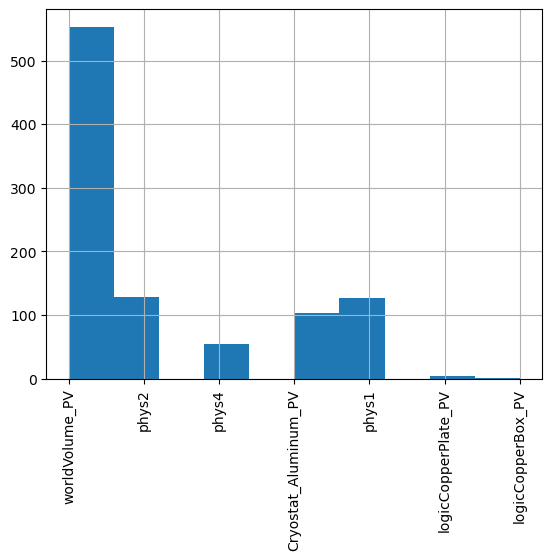

In [114]:
file = loadfile(filenames[0]).fillna('NA')
file = file[~(file.Volume.str.contains('Silicon'))]
# file = file[~(file['Origin Volume'].isin(['phys1', 'phys2', 'phys3']))]
file = file.groupby(['EventID','TrackID','Particle','Origin Volume'])['EnergyDeposited'].sum().reset_index()
file = file[file.EnergyDeposited > 0.2]
file['Origin Volume'].hist()
plt.xticks(rotation = 90)

<Axes: >

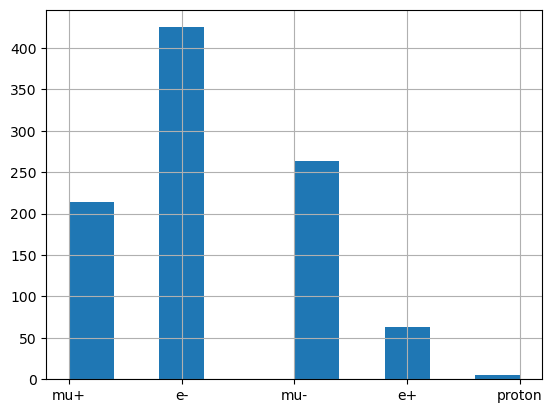

In [115]:
# file[file['Origin Volume'].str.contains('world')]['Particle'].hist()
file['Particle'].hist()

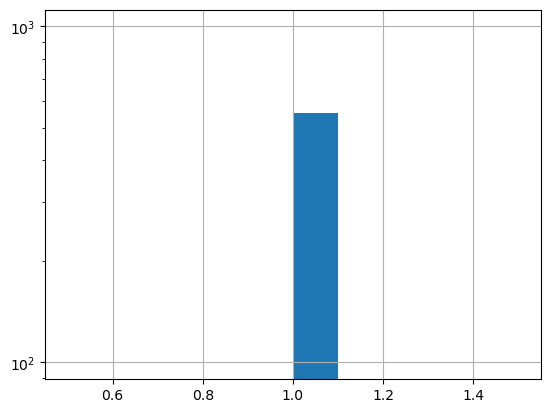

In [116]:
file[file['Origin Volume'].str.contains('world')].groupby(['EventID'])['TrackID'].count().reset_index()['TrackID'].hist()
plt.yscale('log')

## Check for low energy depositions on the TES in cosmic run

100%|██████████| 4096/4096 [00:20<00:00, 203.06it/s]


<Axes: >

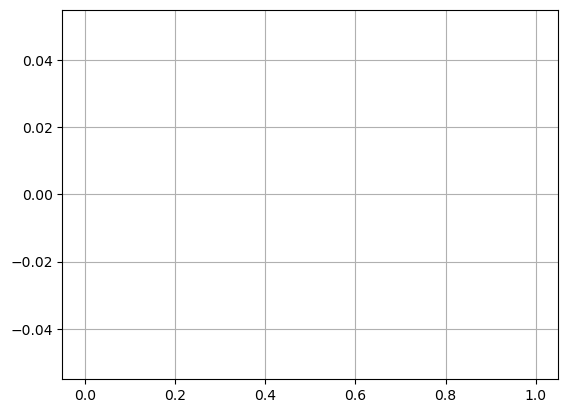

In [112]:
loadfiles = parallel(loadfile)
files = pd.concat(loadfiles(filenames))
tes = files[files.Volume.str.contains('Silicon')]
tes = tes.groupby(['Filename','EventID'])['EnergyDeposited'].sum().reset_index()
tes = tes[(tes.EnergyDeposited > 1 * 10**(-6)) & (tes.EnergyDeposited < 100 * 10**(-6))]
tes.EnergyDeposited.hist(bins = 200)

# Thorium run check

## Double coincidence counting

In [12]:
def processFile(filename):
    file = loadfile(filename)
    file = file[file.Particle != 'alpha']
    # file = file[file.EnergyDeposited > 0.0]
    # file = file.groupby(['EventID', 'TrackID','Volume'])['EnergyDeposited'].sum().reset_index()

    tes = file[file.Volume.str.contains('E')]
    tesIn = tes[tes.MigrantID != -1]
    tesIn = tesIn.drop(columns = ['TrackID'])
    tesIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    tesOut = tes[tes.MigrantID == -1]
    tes = pd.concat([tesOut, tesIn])
    tes = tes.drop(columns = 'MigrantID')
    tes = tes.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    tes = tes[tes.EnergyDeposited > 0.0]
    
    saber = file[file.Volume.str.contains('Saber')]
    saberIn = saber[saber.MigrantID != -1]
    saberIn = saberIn.drop(columns = ['TrackID'])
    saberIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    saberOut = saber[saber.MigrantID == -1]
    saber = pd.concat([saberOut, saberIn])
    saber = saber.drop(columns = 'MigrantID')
    saber = saber.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    saber = saber[saber.EnergyDeposited >= 1.0]
    
    # if len(pd.merge(saber,tes, on = ['EventID', 'TrackID'], how = 'inner')) != len(tes):
    #     print(filename)
    

    double = pd.merge(saber, tes, on = ['EventID', 'TrackID'], how = 'inner')
    # if len(double) > 0:
        # print(double)
    return (len(tes), len(saber), len(double))
    # return len(saber)

processFiles        = parallel(processFile)
processed           = processFiles(filenames)
processed           = np.array(processed).T

tesHits             = sum(processed[0])
saberHits           = sum(processed[1])
triple              = sum(processed[2])

content = f"TES Hits = {tesHits}; saber Hits = {saberHits}; Double Coincidences = {triple}"
print(content)

# print(sum(processed))

100%|██████████| 4096/4096 [00:06<00:00, 612.31it/s]

TES Hits = 10783; saber Hits = 0; Double Coincidences = 0


## TES double coincidence

In [2]:
def processFile(filename):
    file = loadfile(filename)
    file = file[file.Particle != 'alpha']
    file = file[file.EnergyDeposited > 0.0]
    
    tesB = file[file.Volume.str.contains('B')]
    tesIn = tesB[tesB.MigrantID != -1]
    tesIn = tesIn.drop(columns = ['TrackID'])
    tesIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    tesOut = tesB[tesB.MigrantID == -1]
    tesB = pd.concat([tesOut, tesIn])
    tesB = tesB.drop(columns = 'MigrantID')
    tesB = tesB.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    tesB = tesB[tesB.EnergyDeposited >= 0.0]

    tesE = file[file.Volume.str.contains('E')]
    tesIn = tesE[tesE.MigrantID != -1]
    tesIn = tesIn.drop(columns = ['TrackID'])
    tesIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    tesOut = tesE[tesE.MigrantID == -1]
    tesE = pd.concat([tesOut, tesIn])
    tesE = tesE.drop(columns = 'MigrantID')
    tesE = tesE.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    tesE = tesE[tesE.EnergyDeposited >= 0.0]

    TESdoubleCoincidence = pd.merge(tesB, tesE, on = ['EventID', 'TrackID'], how = 'inner')
    return len(TESdoubleCoincidence)

processFiles        = parallel(processFile)
processed           = processFiles(filenames)

doubleCoincidences  = sum(processed)
print("TES double coincidences = ", doubleCoincidences)

100%|██████████| 4096/4096 [00:08<00:00, 490.81it/s]

TES double coincidences =  48


In [13]:
file = loadfile(filenames[0])
saber = file[file.Volume.str.contains('Saber')]
saberIn = saber[saber.MigrantID != -1]
saberIn = saberIn.drop(columns = ['TrackID'])
saberIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

saberOut = saber[saber.MigrantID == -1]
saber = pd.concat([saberOut, saberIn])
saber = saber.drop(columns = 'MigrantID')
saber = saber.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
saber = saber[saber.EnergyDeposited >= 1.1]
saber

,EventID,TrackID,EnergyDeposited
159,576,3,1.67496


In [3]:
data = pd.concat(parallel(loadfile)(filenames))

100%|██████████| 4096/4096 [00:02<00:00, 1464.71it/s]


In [4]:
file = data[data.Volume.str.contains('E')]
file = file.groupby(['EventID'])['EnergyDeposited'].sum().reset_index()
file = file[file.EnergyDeposited >= 10**(-6)]
file

,EventID,EnergyDeposited
21,22,0.009584
143,155,0.025503
245,266,0.094083
285,308,0.028465
342,371,0.020824
...,...,...
228808,243805,0.051613
228829,243828,0.192254
229039,244053,0.019237
229057,244071,0.077407


## Couting alpha secondaries in the saber

In [17]:
def processFile(filename):
    file = loadfile(filename)
    data = file[file.Volume.str.contains('Saber')]
    data = data.groupby(['EventID','TrackID','Particle', 'Origin Volume', 'MigrantID'])['EnergyDeposited'].sum().reset_index()

    originInside = data[data['Origin Volume'].str.contains('Silicon')]
    originInside = originInside.drop(columns = ['TrackID', 'Particle','Origin Volume'])
    originInside = originInside.rename(columns = {'MigrantID':'TrackID', 'EnergyDeposited':'EnergyFromInside'})

    originOutside = data[~(data['Origin Volume'].str.contains('Silicon'))]
    originOutside = originOutside.drop(columns = ['Origin Volume','MigrantID'])
    originOutside = originOutside.rename(columns = {'EnergyDeposited':'EnergyFromOutside'})

    combined = pd.merge(originOutside, originInside, on = ['EventID', 'TrackID'], how = 'left').fillna(0)
    combined['EnergyDeposited'] = combined['EnergyFromOutside'] + combined['EnergyFromInside']
    combined = combined[combined['EnergyDeposited'] > 0.2]
    combined = combined[combined.Particle != 'alpha']
    
    return len(combined)

processFiles        = parallel(processFile)
processed           = processFiles(filenames)
saberHits           = sum(processed)

print(saberHits)

100%|██████████| 1024/1024 [01:02<00:00, 16.34it/s]


1999326


# Na

In [5]:
def triple_check(arr):
    return int('saber1' in arr and any('E' in s for s in arr))

file = pd.concat(parallel(loadfile)(filenames))
file = file[file.EnergyDeposited > 0.0]
file = file[~((file.Particle.str.contains('e')) & (file['Origin Volume'] == 'worldVolume_PV'))]

tes = file[file.Volume.str.contains('E')]
tes = tes.groupby(['EventID'])['EnergyDeposited'].sum().reset_index()

saber = file[file.Volume.str.contains('saber1')]
saber = saber.groupby(['EventID'])['EnergyDeposited'].sum().reset_index()
saber = saber[saber.EnergyDeposited > 0.183]

double = pd.merge(tes,saber, on=['EventID'], how="inner")

double

100%|██████████| 1024/1024 [00:01<00:00, 513.00it/s]


,EventID,EnergyDeposited_x,EnergyDeposited_y


In [32]:
from multiprocessing import Pool
from tqdm import tqdm
import pandas as pd

def process_single_file(filename):
    file = loadfile(filename)
    file = file[file.EnergyDeposited > 0.0]
    tes = file[file.Volume.str.contains('E')]
    tes = tes.groupby(['EventID'])['EnergyDeposited'].sum().reset_index()

    return len(tes)

def init_worker():
    import signal
    signal.signal(signal.SIGINT, signal.SIG_IGN)

def process_files_parallel(filenames):
    with Pool(initializer=init_worker) as pool:
        results = list(tqdm(pool.imap(process_single_file, filenames), total=len(filenames)))

    return sum(results)

# Use the process_files_parallel function to process each file separately in parallel
result = process_files_parallel(filenames)


100%|██████████| 2096/2096 [00:00<00:00, 3490.47it/s]


In [33]:
result

4017

In [8]:
tes

,EventID,EnergyDeposited
0,31,0.004001
1,137,0.015779
2,371,0.381365
3,451,0.038026
4,691,0.006582
...,...,...
4781,975911,0.277179
4782,975990,0.014224
4783,976304,0.308245
4784,976392,0.045102


# Weird stuff check

In [ ]:
weirdFiles = ['TES-run0-rank61_nt_hits.csv', 'TES-run0-rank828_nt_hits.csv', 'TES-run0-rank636_nt_hits.csv', 'TES-run0-rank338_nt_hits.csv', 'TES-run0-rank278_nt_hits.csv',
              'TES-run0-rank443_nt_hits.csv', 'TES-run0-rank319_nt_hits.csv', 'TES-run0-rank849_nt_hits.csv', 'TES-run0-rank512_nt_hits.csv']

In [ ]:
loadfiles = parallel(loadfile)

In [ ]:
weirdData = pd.concat(loadfiles(weirdFiles))

In [ ]:
def processFile(filename):
    file = loadfile(filename)
    file = file[file.Particle != 'alpha']
    # file = file[file.EnergyDeposited > 0.0]
    # file = file.groupby(['EventID', 'TrackID','Volume'])['EnergyDeposited'].sum().reset_index()

    tes = file[file.Volume.str.contains('Silicon')]
    tesIn = tes[tes.MigrantID != -1]
    tesIn = tesIn.drop(columns = ['TrackID'])
    tesIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    tesOut = tes[tes.MigrantID == -1]
    tes = pd.concat([tesOut, tesIn])
    tes = tes.drop(columns = 'MigrantID')
    tes = tes.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    tes = tes[tes.EnergyDeposited >= 0.0]
    
    saber = file[file.Volume.str.contains('Saber')]
    saberIn = saber[saber.MigrantID != -1]
    saberIn = saberIn.drop(columns = ['TrackID'])
    saberIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    saberOut = saber[saber.MigrantID == -1]
    saber = pd.concat([saberOut, saberIn])
    saber = saber.drop(columns = 'MigrantID')
    saber = saber.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    saber = saber[saber.EnergyDeposited >= 0.2]
    
    # if len(pd.merge(saber,tes, on = ['EventID', 'TrackID'], how = 'inner')) != len(tes):
    #     print(filename)
    

    double = pd.merge(tes, saber, on = ['EventID', 'TrackID'], how = 'inner')
    print(double)
    return (len(tes), len(saber), len(double))

processFiles        = parallel(processFile)
processed           = processFiles(weirdFiles)
processed           = np.array(processed).T

tesHits             = sum(processed[0])
saberHits           = sum(processed[1])
triple              = sum(processed[2])

content = f"TES Hits = {tesHits}; saber Hits = {saberHits}; Double Coincidences = {triple}"
print(content)

In [ ]:
weirdData = weirdData[weirdData.Particle != 'alpha']

In [ ]:
weirdTES = weirdData[weirdData.Volume.str.contains('Silicon')]
weirdTESIn = weirdTES[weirdTES.MigrantID != -1]
weirdTESIn = weirdTESIn.drop(columns = ['TrackID'])
weirdTESIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

weirdTESOut = weirdTES[weirdTES.MigrantID == -1]
weirdTES = pd.concat([weirdTESOut, weirdTESIn])
weirdTES = weirdTES.drop(columns = 'MigrantID')
weirdTES = weirdTES.groupby(['Filename','EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
weirdTES = weirdTES[weirdTES.EnergyDeposited >= 0.0]
weirdTES

In [ ]:
weirdSaber = weirdData[weirdData.Volume.str.contains('Saber')]
weirdSaberIn = weirdSaber[weirdSaber.MigrantID != -1]
weirdSaberIn = weirdSaberIn.drop(columns = ['TrackID'])
weirdSaberIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

weirdSaberOut = weirdSaber[weirdSaber.MigrantID == -1]
weirdSaber = pd.concat([weirdSaberOut, weirdSaberIn])
weirdSaber = weirdSaber.drop(columns = 'MigrantID')
weirdSaber = weirdSaber.groupby(['Filename','EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
weirdSaber = weirdSaber[weirdSaber.EnergyDeposited >= 0.0]
weirdSaber

In [ ]:
weird = pd.merge(weirdTES, weirdSaber, on = ['Filename','EventID', 'TrackID'], how = 'left').fillna('what')
weird = weird[weird.EnergyDeposited_y == 'what']
weird

In [ ]:
file = loadfile('TES-run0-rank828_nt_hits.csv')
file = file[(file.EventID == 1297) & (file.TrackID == 25)]

In [ ]:
file

In [ ]:
loadfiles = parallel(loadfile)

In [ ]:
df = pd.concat(loadfiles(filenames))

In [ ]:
df

In [ ]:
dfIn = df[df.MigrantID != -1]
dfIn = dfIn.drop(columns = ['TrackID'])
dfIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)
dfIn

In [ ]:
dfOut = df[df.MigrantID == -1]
dfOut

In [ ]:
df = pd.concat([dfIn, dfOut])
df = df.groupby(['Filename','EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
df = df[df.EnergyDeposited > 0.0]
df
len(df)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
plt.hist(df.EnergyDeposited, bins = 50)